# 8.5.1. One-Hot Encoding

In [2]:
%matplotlib inline

import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [7]:
F.one_hot(torch.tensor([0, 2]), len(vocab))
# len(vocab) = 28

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [9]:
X = torch.arange(10).reshape((2,5))
print(X.shape)
F.one_hot(X.T, 28).shape

torch.Size([2, 5])


torch.Size([5, 2, 28])

# 8.5.2. Initializing the Model Parameters

In [10]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    # Hidden Layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 8.5.3. RNN Model

In [11]:
# 초기화 과정
# (batch size, num of hiddens) 사이즈의 torch를 return 한다.

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [12]:
def rnn(inputs, state, params):
    # 인풋 shape: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X shape: (batch_size, vocab size)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh)+torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [14]:
class RNNModelScratch:
    """
    A RNN Model implemented from scratch
    """
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)        

In [16]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)

Y.shape, len(new_state), new_state[0].shape

#Output shape: (num of time steps x batch size, vocab size)

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

# 8.5.4. Prediction

model이 스스로 업데이트는 하지만, 어떠한 output도 내지 않을 때 이를 'warm - up'이라고 한다. 해당 과정을 거치면, hidden state가 초기화된 값들을 사용할 때보다는 전반적으로 더 나아진다.

In [22]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [23]:
# prefix를 time traveller로 두고, 예측을 진행. 
# 10개의 추가적인 character를 생성해 내는데, 아직 네트워크 학습을 안했기에 
# 적절한 결과가 나오지 않고 있음

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller bexc<unk>dunjx'

# 8.5.5. Gradient Clipping

문자열의 길이가 매우 큰 경우에 numerical instability를 불러올 수 있다. gradient가 폭발하거나 사라져 버릴 수 있다는 말인데, 이를 해결하기 위해서는 학습 과정에 추가적인 처리가 필요하다.

gradient가 일정 threshold를 넘기는 경우에는 clipping을 해준다. clipping이라는 것은, gradient의 L2 norm으로 나눠주는 방식이다.

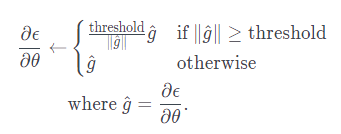

cliping이 없을 때, gradient가 너무 뛰어서 global minimum에 도달하지 못하고 너무 엉뚱한 방향으로 향하게 되지만, clipping을 하게 되면 gradient vector가 방향은 유지하되 적은 값만큼 이동하여 도달하려고 하는 곳으로 '안정'하게 내려가게 된다.

In [24]:
def grad_clipping(net, theta):
    """
    Clipping the gradient
    """
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm>theta:
        for param in params:
            param.grad[:] *= theta/norm

# 8.5.6. Training

학습할 때 유의할 점.

1. 순서열 데이터에 대한 다른 sampling method들은 각각 hidden state의 초기화에서 다른 결과를 낼 것.
2. model parameter들을 업데이트하기 전에, gradient clipping을 진행할 것. 이는 gradient가 매우 커져도 모델이 발산하지 않음을 의미한다.
3. Perplexity(언어모델의 Generation 성능 파악 지표)를 사용할 것.

특히, sequential partitioning이 사용될 때, hidden state를 각 에폭 시작 시점에서 한번 진행한다.



Specifically, when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch. Since the  subsequence example in the next minibatch is adjacent to the current  subsequence example, the hidden state at the end of the current minibatch will be used to initialize the hidden state at the beginning of the next minibatch. In this way, historical information of the sequence stored in the hidden state might flow over adjacent subsequences within an epoch. However, the computation of the hidden state at any point depends on all the previous minibatches in the same epoch, which complicates the gradient computation. To reduce computational cost, we detach the gradient before processing any minibatch so that the gradient computation of the hidden state is always limited to the time steps in one minibatch.

When using the random sampling, we need to re-initialize the hidden state for each iteration since each example is sampled with a random position. Same as the train_epoch_ch3 function in Section 3.6, updater is a general function to update the model parameters. It can be either the d2l.sgd function implemented from scratch or the built-in optimization function in a deep learning framework.

In [26]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """
    한 개 에폭에 대해서 net 학습
    """
    state, times = None, d2l.Timer()
    metric = d2l.Accumulator(2) # Sum of training loss, no. of tokens
    
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 첫번째 iteration이거나, random sampling을 사용하는 경우,
            # state를 초기화
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l*y.numel(), y.numel())
    return match.exp(metric[0]/metric[1]), metric[1]/timer.stop()
            

In [ ]:
def train_ch8(net, train_iter)